# Wine Type Classifier
#####  @ Haim Goldfisher

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Quick review:
##### Link to the dataset: https://www.kaggle.com/ahmettezcantekin/beginner-datasets
I Chose wine as my dataset. I would like to create a model which will predict the type of the wine(red/white), according to it's features.
At first, I thought that this model might be a little stupid. We have eyes, we also have mouth. There is no problem to recognize the difference between white and red wine. However, a model has no senses. It can't taste the wine or see it color. The idea that we can use only data to predict at first the color of the wine, and after it to connect person to specific wine, is a big thing. This model may looks a little boring to you, but to me it is the first step of a long journey.

Firstly, we will upload the dataset:

In [ ]:
wine = pd.read_csv('../input/beginner-datasets/beginner_datasets/wine.csv')

wine # display the first and last 5 rows

Explantion for the features:
- **fixed acidity:** most acids involved with wine or fixed or nonvolatile (do not evaporate readily).
- **volatile acidity:** the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.
- **citric acid:** found in small quantities, citric acid can add 'freshness' and flavor to wines.
- **residual sugar:** the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
- **chlorides:** the amount of salt in the wine.
- **free sulfur dioxide:** the free form of $SO_2$ exists in equilibrium between molecular $SO_2$ (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
- **total sulfur dioxide:** amount of free and bound forms of $SO_2$; in low concentrations, $SO_2$ is mostly undetectable in wine, but at free $SO_2$ concentrations over 50 ppm, $SO_2$ becomes evident in the nose and taste of wine.
- **density:** the density of water is close to that of water depending on the percent alcohol and sugar content.
- **pH:** describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
- **sulphates:** a wine additive which can contribute to sulfur dioxide gas $(SO_2)$ levels, wich acts as an antimicrobial and antioxidant.
- **alcohol:** the percent alcohol content of the wine.
- **quality:** score between 0 and 10.
- **type:** red/white.


In [ ]:
wine.info() # we would like to see if we have null values in the df

In [ ]:
wine.shape # 6497 rows and 13 columns

In [ ]:
wine.isnull().sum() #for NaN

In [ ]:
wine.duplicated().sum() # duplicates may point on the same wine, it can make our model unstable

We have 1,177 duplicated rows, we can infer that it referrence to the same wine. Let's drop those rows for better results for our model.

In [ ]:
wine = wine.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
wine.shape # 5320 rows and 13 columns

At first, we had 6,497 rows. Now we have 5,320 rows.

In [ ]:
count_cat = wine.nunique() # it shows us how much unique examples we have in each feature

In [ ]:
count_cat

It let us understand how much "categories" we have for each column.

In [ ]:
wine["type"].value_counts() # it let us understand the number of the examples we have in the dataset

In [ ]:
# The distribution of the examples in our dataset
wine["type"].value_counts("white")*100 # in %
wine["type"].value_counts("red")*100 # in %

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x = wine['type']); # we will plot it for better illustration

It seems that we have much more white wine than red wine. It will be usefull for our dummy classifier.

In [ ]:
# Pie chart
labels = ['White', 'Red'] # every label represnts a type
pie_x = 0.753886 # the distribution
pie_y = 0.246114 # the distribution
sizes = [pie_x,pie_y] # we have two types and their distribution
explode = (0, 0.15) # the distance between the pic slicers
col_pie = ["silver","red"] # for the colors
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels,colors=col_pie, autopct='%1.1f%%',
        shadow=True, startangle=93)
# equal aspect ratio ensures that pie is drawn as a circle
plt.title("Types division:", size=20, color="blue")
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [ ]:
# another plot to show us more intersting details about the dataset
plt.figure(figsize = (16,6))
plt.title("The quality distribution of the wine according to it's type", size=18, color='b')
sns.countplot(wine['quality'], hue = wine['type']);

We can see that we have some quality for each wine. Let's take a look on it:

In [ ]:
wine["quality"].value_counts() # the amount of wine we have from each quality number

We can also display this by a dataframe:

In [ ]:
red_per_quality = wine.loc[wine["type"]=='red']["quality"].value_counts() # only the red wine, the sum is sorted by quality
white_per_quality = wine.loc[wine["type"]=='white']["quality"].value_counts() # only white...
quality_dist = pd.DataFrame({ # new df for our two new series
        'red': red_per_quality,
        'white':white_per_quality})
quality_dist.fillna(value = 0, inplace=True) # if we dont have any data = we dont't have wine from that quality

quality_dist

We can also take only the red wine which it's quality is 6:

In [ ]:
red_wine = wine.loc[wine["type"]=='red'] # we chose only red wine
red_wine_5 = red_wine.loc[red_wine["quality"]==6] # we chose only quality 6
red_wine_5

Let's try something else, we will groupby the wine into type groups to see which one has a greater quality:

In [ ]:
df_types = wine.groupby('type') #by type
df_types

In [ ]:
df_types.quality.mean() # the mean of the quality for each type

As we can see, the white wine that we have in the dataset, has a little bit better quality than the red wine.

In [ ]:
encoder = LabelEncoder()
wine['type'] = encoder.fit_transform(wine['type'])
# red = 0
# white = 1

In [ ]:
wine["type"].value_counts()

In [ ]:
wine

In [ ]:
#I want to know the correalation between each feature
plt.figure(figsize=(20, 10))
sns.heatmap(wine.corr(), square=True, annot=True, cmap="Blues");

Heatmap is a super important tool, because it tells us the bigger story.
As we can see, total sulfur dioxide has a huge effect on the type of the wine (0.7 of correalation). free sulfur dioxide takes the 2nd place with 0.47 of correalation. After it, the residual sugar with 0.35 of correalation.
Another intersting thing is the fact that the quality of the wine has a connection to the type of the wine. It will be intresting to find out which one of the types has the higher quality.

We would like to see the impact of total sulfur dioxide, free sulfur dioxide and residual sugar on the wine's type. Let's go back to the graphs.

In [ ]:
wine.groupby('type')['total sulfur dioxide'].plot(title="Type correlation with total sulfur dioxide", legend=True);
# the most important thing here is to watch the difference between the red and white wine
# we can also see that there are a few outliers 

In [ ]:
wine.groupby('type')['free sulfur dioxide'].plot(title="Type correlation with free sulfur dioxide", legend=True);

In [ ]:
wine.groupby('type')['residual sugar'].plot(title="Type correlation with residual sugar", legend=True);

In [ ]:
wine.describe() # more info about our dataset before the models part

# Scaling

In [ ]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
ss = StandardScaler()
df = wine
df[features] = ss.fit_transform(df[features])
df.head(3)

In [ ]:
#df['type']=df['type'].map({'red':0,'white':1})
#df

### Training - Testing split

In [ ]:
target=df['type'] # the feature we would like to predict, the type of the wine
data=df.drop(['type'], axis = 1) # we will drop y from x, because we want to predict it
X_train,X_test,y_train,y_test = train_test_split(data,target,random_state=0) #train\test split

The default split is 75% train , 25% test.

In [ ]:
X_train.shape # 3990 rows, 12 columns

In [ ]:
X_test.shape # 1330 rows, 12 columns

In [ ]:
y_train.shape # 3990 rows, one column

In [ ]:
y_test.shape # 1330 rows, one columns

# Dummy Classifier

#### Our model must be better than this model.

In [ ]:
# our options: 'most_frequent', 'stratified', 'uniform', 'constant', 'prior')
# I chose the best dummy classifier from all those options (please, believe me)

dm = DummyClassifier(strategy='most_frequent', random_state=0)
# random_state = 0 assure the result will be the same every time we run the model (no random results)
dm.fit(X_train,y_train) # training the model
dm

In [ ]:
y_pred = dm.predict(X_test) # predict the result

In [ ]:
print(classification_report(y_test,y_pred))

The most frequent strategy goes always after the majority. In our case, that every wine is white, because 75% of the wine is white.

Here's a reminder for a confusion matrix values:

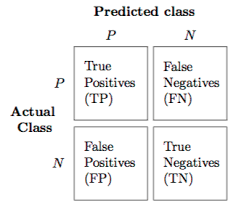

In [ ]:
cm_dm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm_dm,annot=True,annot_kws = {'size':15},fmt=".0f")
plt.xlabel("Predict")
plt.ylabel("Actual") #up and right = FP , down and right = FN

## ROC Curve

#### A graph showing the performance of an ambiguous classifier, due to the decision threshold set for it. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) under different acceptance thresholds.

In [ ]:
fpr, tpr, _= roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="auc="+str(auc), color='r')
plt.box(False)
plt.title('ROC CURVE Dummy Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

dummy_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

# KNN - K-Nearest Neighbors

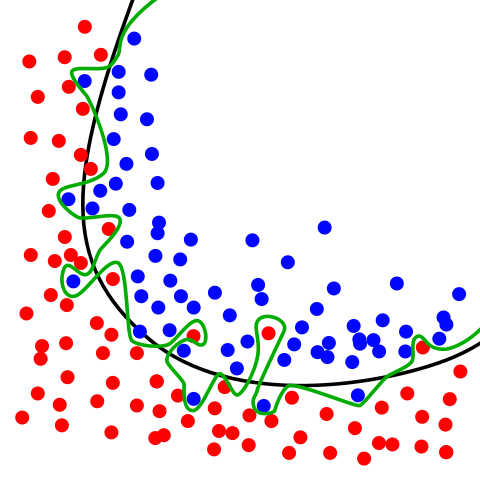

#### The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print (classification_report(y_test, y_pred))

### Cross validation:

#### The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset.


##### For illustration:

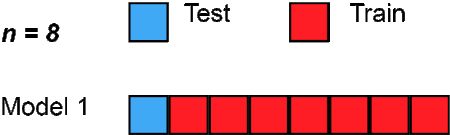

In [ ]:
k_range = list(range(3,51)) # we will test k values in range 3-50
weight_op = ['uniform', 'distance'] # we will test the knn methods uniform & distance
d = {'n_neighbors' :k_range, 'weights': weight_op}

In [ ]:
grid_temp = GridSearchCV(knn, d, cv=10, scoring='accuracy') # we chose model, d(range, methods), num of cv groups and scoring method
grid_temp.fit(data, target)
print("score:",grid_temp.best_score_," params:",grid_temp.best_params_)

As we can see, the grid search found the ideal k (6) and knn strategy (distance) for us. Let's use them for better performance for our model.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 6, weights = 'distance')
knn.fit(X_train,y_train)
knn

In [ ]:
y_pred = knn.predict(X_test)
y_pred

In [ ]:
print (classification_report(y_test,y_pred))

In [ ]:
cm_knn = confusion_matrix(y_test,y_pred)
sns.heatmap(cm_knn,annot=True,annot_kws = {'size':15},fmt=".0f")
plt.xlabel("Predict")
plt.ylabel("Actual") #up and right = FP , down and right = FN

## ROC Curve

In [ ]:
fpr, tpr, _= roc_curve(y_test, y_pred)
auc= roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="auc="+str(auc), color='g')
plt.box(False)
plt.title('ROC CURVE KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

knn_auc = round(auc,3)*100

print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

# Decision Tree

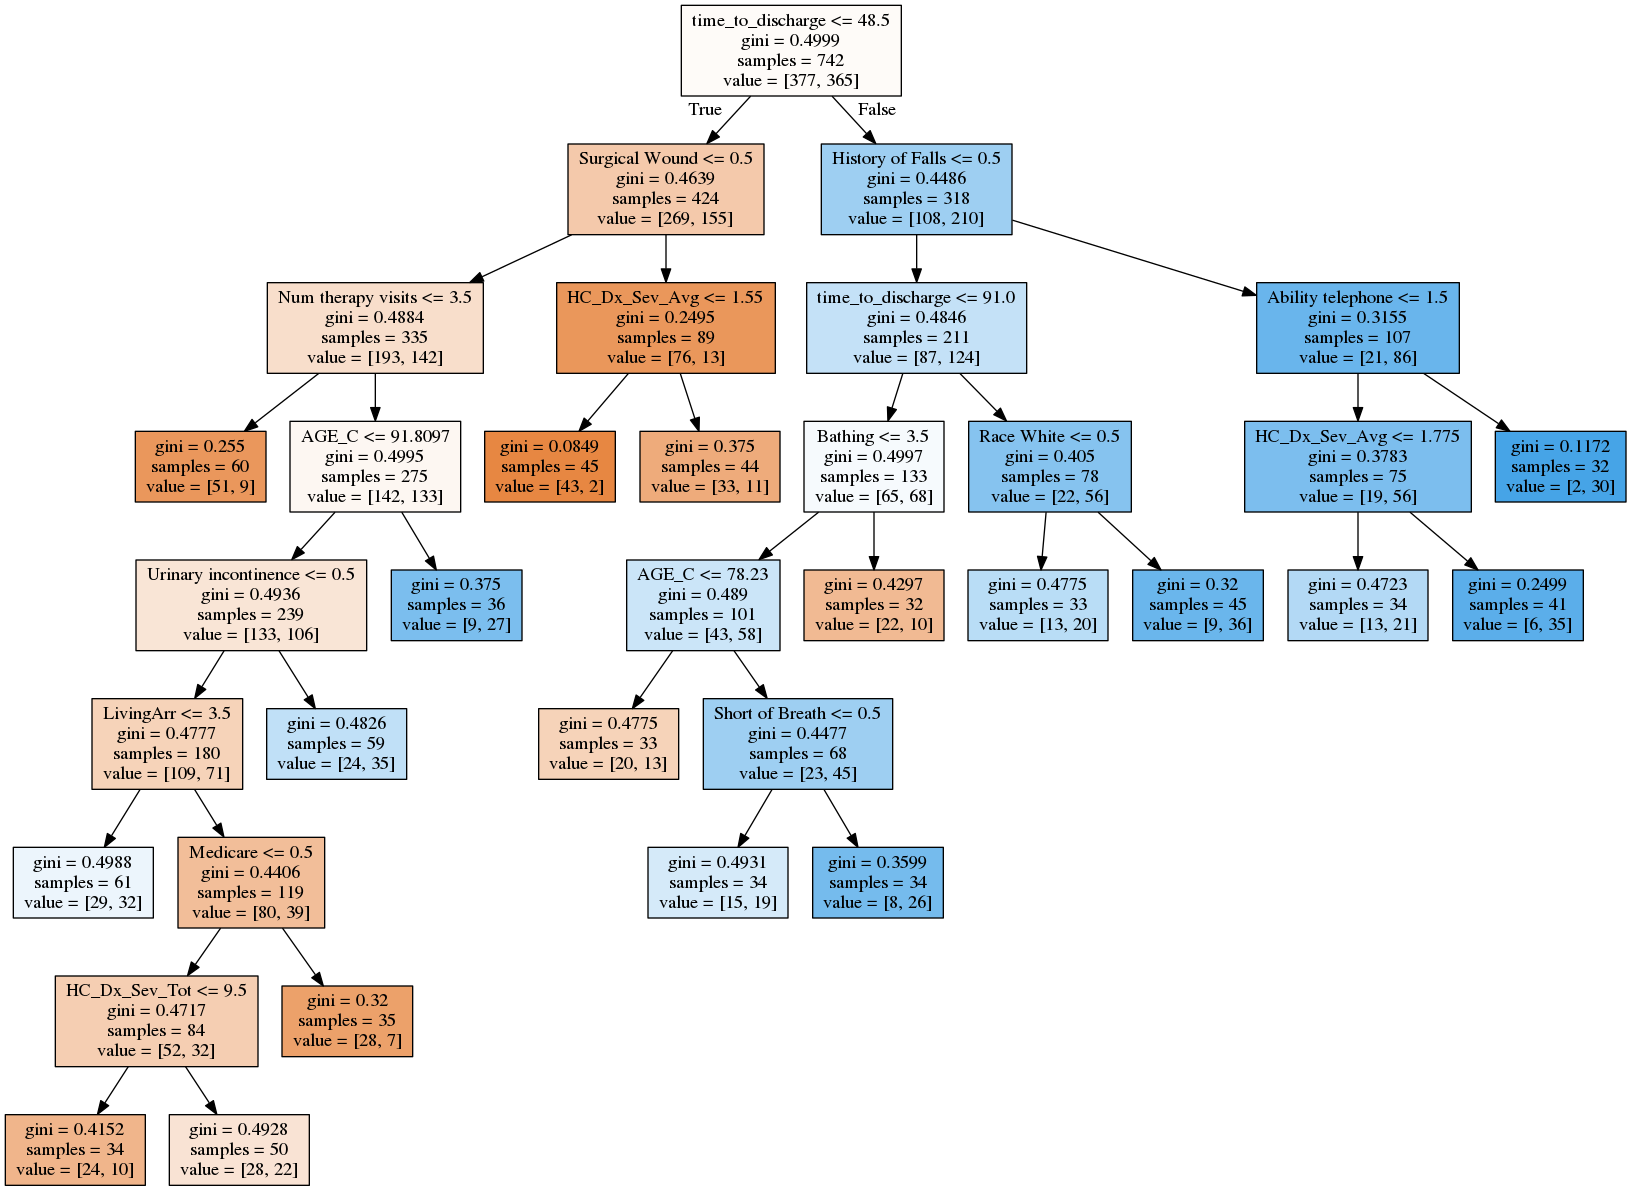

#### A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. Criterion is the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Splitter is the strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

In [ ]:
dct = DecisionTreeClassifier(random_state=0) # gini and best are the default
dct = dct.fit(X_train,y_train)
dct

In [ ]:
y_pred = dct.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

α (alpha) is a tuning parameter that we finding using cross validation.

In [ ]:
path = dct.cost_complexity_pruning_path(X_train,y_train)
alphas = path.ccp_alphas
impurities = path.impurities
# it returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process
alphas

In [ ]:
d = {'ccp_alpha':alphas}
d

### Cross validation:

In [ ]:
fig, ax = plt.subplots()
ax.plot(alphas[:-1], impurities[:-1], marker = 'o', drawstyle = "steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");
#  as alpha increases, more of the tree is pruned, which increases the total impurity of its leaves

In [ ]:
grid_dct = GridSearchCV(dct, d, cv=10, scoring='accuracy')
grid_dct.fit(data, target)
print("score:", grid_dct.best_score_, " params:", grid_dct.best_params_)

As we can see, the grid search found the optimal alpha for us. We will use that alpha to improve our model results

In [ ]:
dct = DecisionTreeClassifier(ccp_alpha = 0.0004761904761904761)
dct = dct.fit(X_train, y_train)
dct

In [ ]:
y_pred = dct.predict(X_test)
y_pred

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
cm_dct = confusion_matrix(y_test,y_pred)
sns.heatmap(cm_dct,annot=True,annot_kws = {'size':15},fmt=".0f")
plt.xlabel("Predict")
plt.ylabel("Actual") #up and right = FP , down and right = FN

Let's take a look at the decision tree of our model:

In [ ]:
plt.figure(figsize=(15,7.5))
plot_tree(dct,filled=True);

## ROC Curve

In [ ]:
fpr, tpr, _= roc_curve(y_test, y_pred)
auc= roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="auc="+str(auc), color='b')
plt.box(False)
plt.title('ROC CURVE Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

dct_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

# Logistic Regression

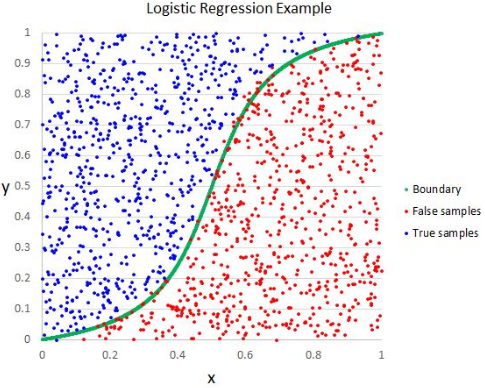

#### A statistical model that describes a possible relationship between a qualitative / categorical variable, known as the "explained variable", and other variables called "explanatory variables". The explanatory variables can be qualitative or quantitative. The model makes it possible to estimate the extent of the effect of a change in its value on each of the variables that explain the value of the explained variable. In other words, the model makes it possible to estimate correlations between the explanatory variables and the explained variable.

In [ ]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".0f")
plt.xlabel("Predict")
plt.ylabel("Actual") #up and right = FP , down and right = FN

In [ ]:
print(metrics.accuracy_score(y_test, predictions))

## ROC Curve

In [ ]:
fpr, tpr, _= roc_curve(y_test, predictions)
auc= roc_auc_score(y_test, predictions)
plt.plot(fpr, tpr, label="auc="+str(auc), color='orange')
plt.box(False)
plt.title('ROC CURVE Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

lr_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

# Conclusion

In [ ]:
print("The score for the models:\n")
print("Dummy Classifer:      ",dummy_auc,"%")
print("KNN:                  ",knn_auc,"%")
print("Decision Tree:        ",dct_auc,"%")
print("Logistic Regression:  ",lr_auc,"%")

## It can be concluded that KNN is the most accurate model for our dataset, with 98.7 percentages of success.